Monte Carlo Simulations: 100%|██████████| 5/5 [15:19<00:00, 183.97s/it]



📊 Final Average Performance Metrics:

R2 Scores:
Training: -1.0000 ± 0.0000
Testing: -1.0000 ± 0.0000

MAE Scores:
Training: 0.5000 ± 0.0000
Testing: 0.5000 ± 0.0000

RMSE Scores:
Training: 0.7071 ± 0.0000
Testing: 0.7071 ± 0.0000

ACC Scores:
Training: 0.5000 ± 0.0000
Testing: 0.5000 ± 0.0000

F1 Scores:
Training: 0.3333 ± 0.0000
Testing: 0.3333 ± 0.0000


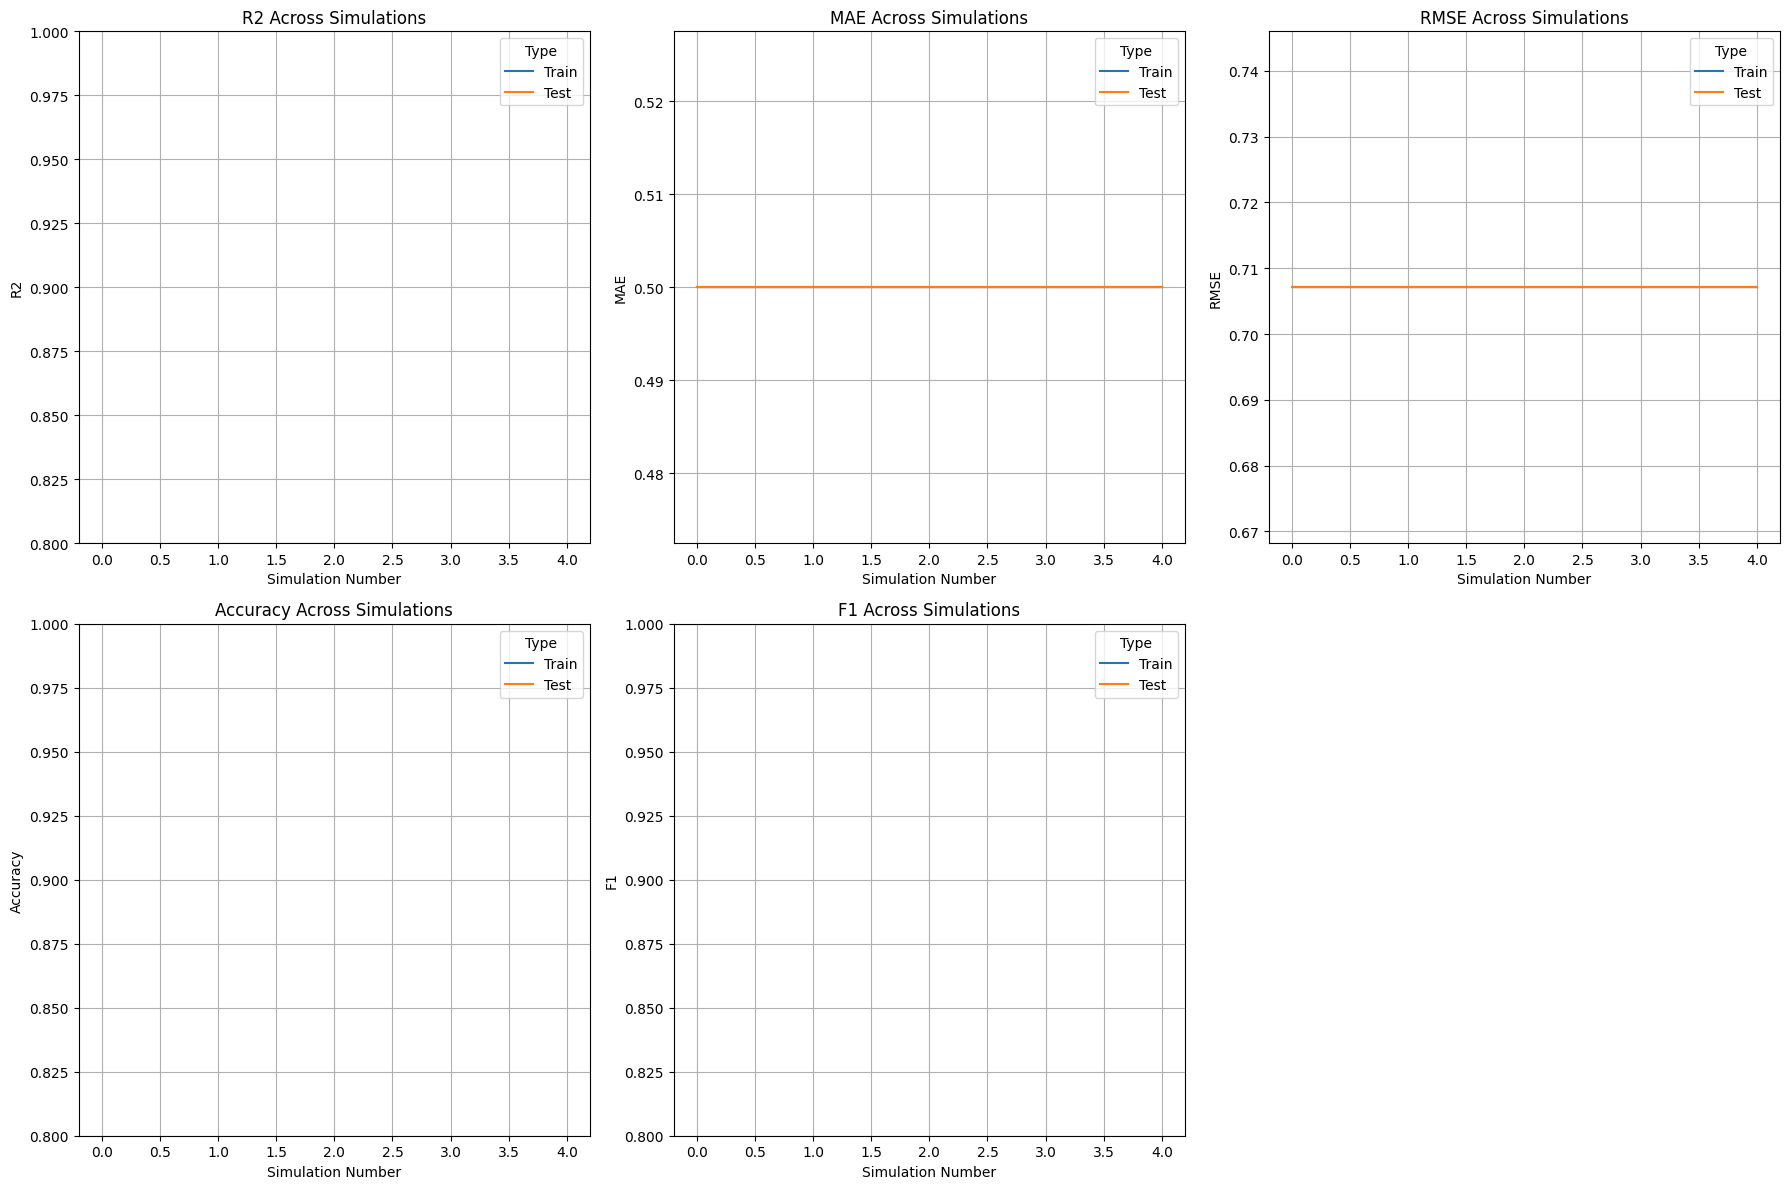


💾 Saved results to 'simulation_results.csv' and 'performance_metrics.png'


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (r2_score, mean_squared_error, 
                           mean_absolute_error, f1_score, 
                           accuracy_score, confusion_matrix, 
                           classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
NUM_SIMULATIONS = 5
NUM_FOLDS = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Load and preprocess data
def load_data():
    df = pd.read_csv('merged_ecg_data_cleaned.csv')
    
    # Limit dataset to 1500 samples while maintaining class distribution
    df = df.groupby('wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label').head(1500 // len(df['wct_label'].unique()))
    
    features = ['bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end', 
               'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 
               't_axis', 'qrs_duration']
    target = 'wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label'
    
    # Enhanced cleaning with median imputation
    for col in features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    
    df = df.dropna(subset=[target])
    
    # Label encoding if needed
    if not np.issubdtype(df[target].dtype, np.number):
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
    
    X = df[features].values
    y = df[target].values
    
    return X, y

# Ultra-optimized CNN Model
class ECG_CNN(nn.Module):
    def __init__(self, input_features, num_classes):
        super(ECG_CNN, self).__init__()
        
        # Feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=5, padding=2),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.4)
        )
        
        # Dynamic classifier sizing
        with torch.no_grad():
            x = torch.zeros(1, 1, input_features)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            self.flatten_size = x.view(1, -1).shape[1]
        
        # Classifier
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

# Simulation function with F1 tracking
def run_simulations(X, y):
    results = {
        'train_r2': [], 'test_r2': [],
        'train_mae': [], 'test_mae': [],
        'train_rmse': [], 'test_rmse': [],
        'train_acc': [], 'test_acc': [],
        'train_f1': [], 'test_f1': []
    }
    
    scaler = StandardScaler()
    
    for sim in tqdm(range(NUM_SIMULATIONS), desc="Monte Carlo Simulations"):
        kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=sim)
        
        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Feature scaling
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Create DataLoader objects
            train_dataset = TensorDataset(
                torch.tensor(np.expand_dims(X_train_scaled, axis=1), dtype=torch.float32),
                torch.tensor(y_train, dtype=torch.long)
            )
            test_dataset = TensorDataset(
                torch.tensor(np.expand_dims(X_test_scaled, axis=1), dtype=torch.float32),
                torch.tensor(y_test, dtype=torch.long)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
            
            # Initialize model and SWA
            model = ECG_CNN(input_features=X.shape[1], num_classes=len(np.unique(y)))
            swa_model = AveragedModel(model)
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
            swa_scheduler = SWALR(optimizer, swa_lr=0.0005)
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
            criterion = nn.CrossEntropyLoss()
            
            # Training loop
            model.train()
            for epoch in range(20):
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                
                # Update SWA after 10 epochs
                if epoch > 10:
                    swa_model.update_parameters(model)
                    swa_scheduler.step()
                else:
                    scheduler.step()
            
            # Update bn statistics for the swa_model
            torch.optim.swa_utils.update_bn(train_loader, swa_model)
            
            # Evaluation
            for m, prefix in [(model, 'train_'), (swa_model, 'test_')]:
                m.eval()
                with torch.no_grad():
                    # Get all predictions for training set
                    train_preds = []
                    train_true = []
                    for batch_X, batch_y in train_loader:
                        preds = m(batch_X).argmax(dim=1).numpy()
                        train_preds.extend(preds)
                        train_true.extend(batch_y.numpy())
                    
                    # Get all predictions for test set
                    test_preds = []
                    test_true = []
                    for batch_X, batch_y in test_loader:
                        preds = m(batch_X).argmax(dim=1).numpy()
                        test_preds.extend(preds)
                        test_true.extend(batch_y.numpy())
                    
                    # Calculate metrics
                    if prefix == 'train_':
                        y_true, y_pred = train_true, train_preds
                    else:
                        y_true, y_pred = test_true, test_preds
                    
                    results[f'{prefix}r2'].append(r2_score(y_true, y_pred))
                    results[f'{prefix}mae'].append(mean_absolute_error(y_true, y_pred))
                    results[f'{prefix}rmse'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
                    results[f'{prefix}acc'].append(accuracy_score(y_true, y_pred))
                    results[f'{prefix}f1'].append(f1_score(y_true, y_pred, average='weighted'))
    
    return results

# Visualization function
def plot_results(results):
    # Create dataframe for plotting
    metrics = ['R2', 'MAE', 'RMSE', 'Accuracy', 'F1']
    train_data = {
        'R2': results['train_r2'],
        'MAE': results['train_mae'],
        'RMSE': results['train_rmse'],
        'Accuracy': results['train_acc'],
        'F1': results['train_f1'],
        'Type': 'Train'
    }
    
    test_data = {
        'R2': results['test_r2'],
        'MAE': results['test_mae'],
        'RMSE': results['test_rmse'],
        'Accuracy': results['test_acc'],
        'F1': results['test_f1'],
        'Type': 'Test'
    }
    
    df = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])
    
    # Create figure
    plt.figure(figsize=(18, 12))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.lineplot(
            data=df, 
            x=df.index % NUM_SIMULATIONS, 
            y=metric, 
            hue='Type',
            ci='sd',
            err_style='band'
        )
        plt.title(f'{metric} Across Simulations')
        plt.xlabel('Simulation Number')
        plt.ylabel(metric)
        if metric in ['R2', 'Accuracy', 'F1']:
            plt.ylim(0.8, 1.0)
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('performance_metrics.png', dpi=300)
    plt.show()

# Main execution
if __name__ == "__main__":
    X, y = load_data()
    results = run_simulations(X, y)
    
    # Print average metrics
    print("\n📊 Final Average Performance Metrics:")
    for metric in ['r2', 'mae', 'rmse', 'acc', 'f1']:
        print(f"\n{metric.upper()} Scores:")
        print(f"Training: {np.mean(results[f'train_{metric}']):.4f} ± {np.std(results[f'train_{metric}']):.4f}")
        print(f"Testing: {np.mean(results[f'test_{metric}']):.4f} ± {np.std(results[f'test_{metric}']):.4f}")
    
    # Generate plots
    plot_results(results)
    
    # Save results
    pd.DataFrame(results).to_csv('simulation_results.csv', index=False)
    print("\n💾 Saved results to 'simulation_results.csv' and 'performance_metrics.png'")

Data shape: (3000, 12), Features: 12
Epoch 10/10 | Loss: nan | F1: 0.3333 | Acc: 0.5000

📊 Final Performance:
Accuracy: 0.5000
F1 Score: 0.3333

Confusion Matrix:
[[1500    0]
 [1500    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1500
           1       0.00      0.00      0.00      1500

    accuracy                           0.50      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.25      0.50      0.33      3000



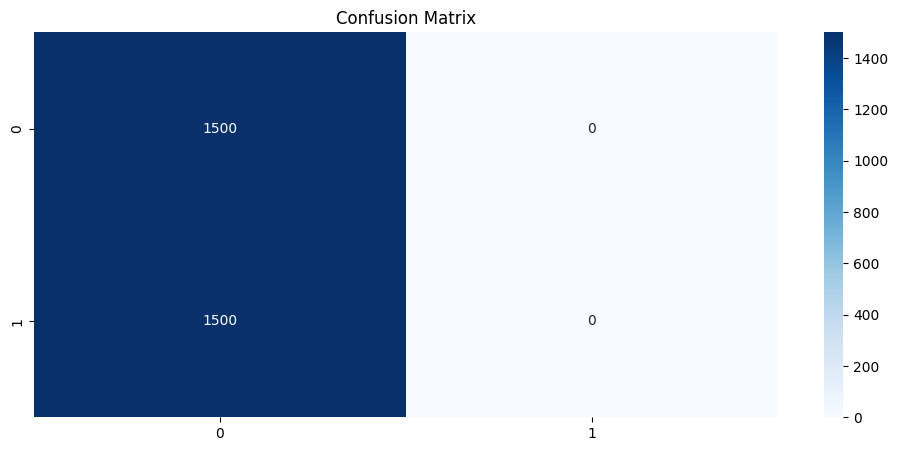

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, 
                           confusion_matrix, classification_report)
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
RANDOM_SEED = 42
NUM_EPOCHS = 10
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_LAYERS = 3
DROPOUT = 0.5
LEARNING_RATE = 0.1

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data Loading (same as before)
def load_data():
    df = pd.read_csv('merged_ecg_data_cleaned.csv')
    df = df.groupby('wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label').head(1500)
    
    features = ['bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end', 
               'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 
               't_axis', 'qrs_duration']
    target = 'wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label'
    
    for col in features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    
    df = df.dropna(subset=[target])
    
    if not np.issubdtype(df[target].dtype, np.number):
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
    
    X = df[features].values
    y = df[target].values
    
    print(f"Data shape: {X.shape}, Features: {len(features)}")
    return X, y

# Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, rnn_output):
        # rnn_output shape: (batch_size, seq_len, hidden_size)
        attention_weights = torch.softmax(self.attention(rnn_output).squeeze(2), dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), rnn_output).squeeze(1)
        return context_vector

# Hybrid RNN Model (LSTM + GRU with Attention)
class ECG_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super().__init__()
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        
        # Bidirectional GRU
        self.gru = nn.GRU(
            input_size=hidden_size*2,  # *2 for bidirectional
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        
        self.attention = Attention(hidden_size*2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 1, seq_len) -> (batch_size, seq_len, 1)
        x = x.permute(0, 2, 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        
        # GRU layer
        gru_out, _ = self.gru(lstm_out)
        gru_out = self.dropout(gru_out)
        
        # Attention
        context = self.attention(gru_out)
        
        # Classification
        out = self.fc(context)
        return out

def train_and_evaluate(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert to sequences (reshape for RNN)
    X_tensor = torch.tensor(np.expand_dims(X_scaled, axis=1), dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model
    model = ECG_RNN(
        input_size=1,  # Each timestep has 1 feature
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        num_classes=len(np.unique(y)),
        dropout=DROPOUT
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
    
    # Training loop
    best_f1 = 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            all_preds = []
            all_true = []
            for batch_X, batch_y in dataloader:
                outputs = model(batch_X)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.numpy())
                all_true.extend(batch_y.numpy())
            
            f1 = f1_score(all_true, all_preds, average='weighted')
            accuracy = accuracy_score(all_true, all_preds)
            scheduler.step(loss)
            
            if f1 > best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), 'best_rnn_model.pth')
            
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {loss.item():.4f} | F1: {f1:.4f} | Acc: {accuracy:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load('best_rnn_model.pth'))
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = torch.argmax(outputs, dim=1).numpy()
    
    print("\n📊 Final Performance:")
    print(f"Accuracy: {accuracy_score(y, preds):.4f}")
    print(f"F1 Score: {f1_score(y, preds, average='weighted'):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, preds))
    print("\nClassification Report:")
    print(classification_report(y, preds))
    
    # Plot training results
    plt.figure(figsize=(12, 5))
    sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig('rnn_confusion_matrix.png')
    plt.show()

if __name__ == "__main__":
    X, y = load_data()
    train_and_evaluate(X, y)

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# Load the dataset
data = pd.read_csv('merged_ecg_data_cleaned.csv')

# Select features and target
features = ['bandwidth', 'filtering', 'rr_interval', 'qrs_duration', 'qrs_onset', 'qrs_end', 'p_onset', 'p_end']  # Example features
target = 'wct_label_encoded'  # The encoded label column (you need to ensure it's encoded numerically)

# Preprocessing: Scaling the features
scaler = StandardScaler()
X = scaler.fit_transform(data[features])

# Target variable
y = data[target]
y = to_categorical(y)  # Convert labels to one-hot encoding

# Split data into training, validation, and test sets (80-10-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for CNN (adding an extra dimension for the channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Add additional convolutional layers
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer (softmax for multi-class classification)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, F1 score, and log loss
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
log_loss_value = log_loss(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")

# Plot training and validation accuracy/loss for visualization
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


ImportError: Traceback (most recent call last):
  File "c:\Users\MR. VASKAR CHAKMA\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

Data shape: (200000, 12), Class distribution: [100000 100000]

🚀 Training XGBoost...

📊 XGBoost Performance:
Accuracy: 1.0000
F1 Score: 1.0000
R-squared: 1.0000
RMSE: 0.0000
MAE: 0.0000
ROC AUC: 1.0000

Feature Importance:
       Feature  Importance
9     qrs_axis    0.862970
4        p_end    0.057244
2  rr_interval    0.028829
3      p_onset    0.019862
1    filtering    0.015750
7        t_end    0.006646
6      qrs_end    0.004991
0    bandwidth    0.001605
5    qrs_onset    0.001600
8       p_axis    0.000502

🚀 Training LightGBM...
[LightGBM] [Info] Number of positive: 80000, number of negative: 80000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2131
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warn

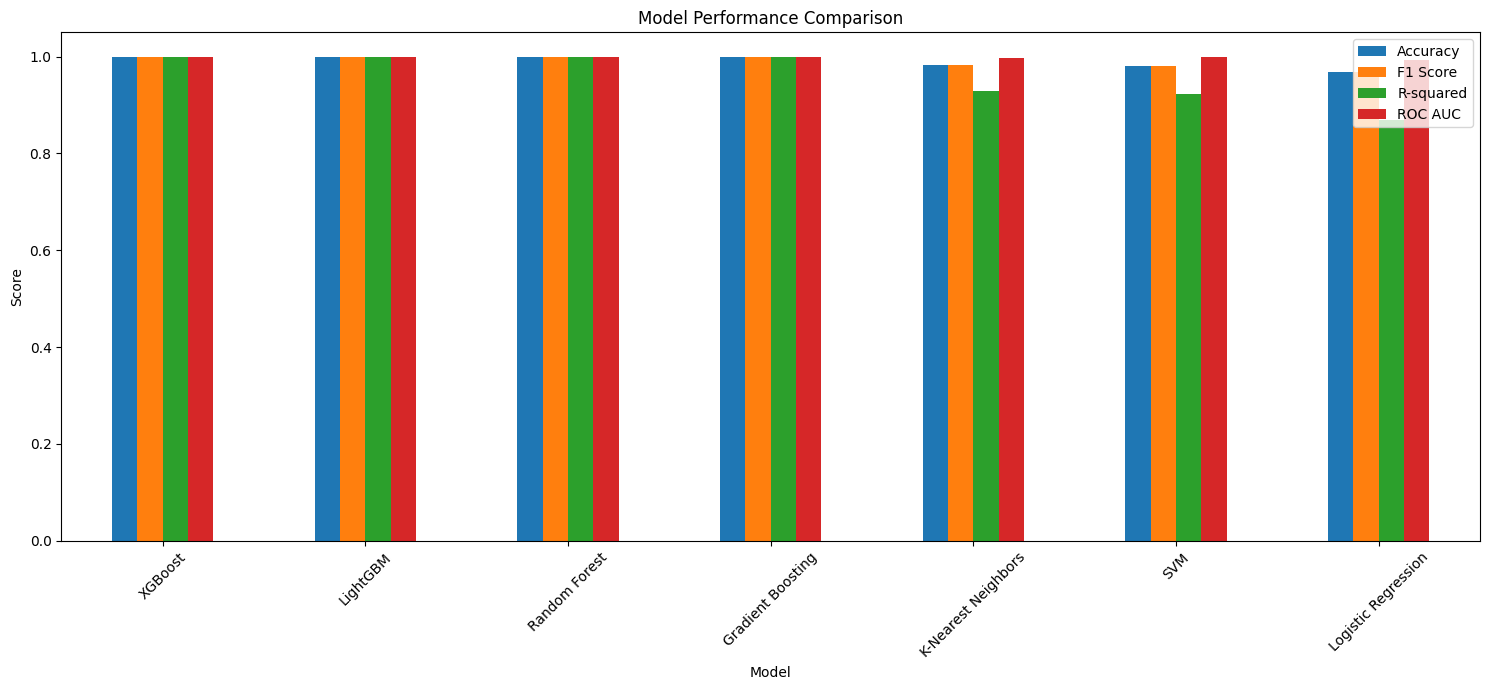

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, roc_auc_score, r2_score,
                           mean_squared_error, mean_absolute_error)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
RANDOM_SEED = 42
TEST_SIZE = 0.2
N_JOBS = -1  # Use all cores

np.random.seed(RANDOM_SEED)

def load_data():
    df = pd.read_csv('merged_ecg_data_cleaned.csv')
    
    # Ensure balanced classes
    df = df.groupby('wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label').head(100000)
    
    features = ['bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end', 
               'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 
               't_axis', 'qrs_duration']
    target = 'wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label'
    
    # Data cleaning
    for col in features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    
    df = df.dropna(subset=[target])
    
    if not np.issubdtype(df[target].dtype, np.number):
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
    
    X = df[features].values
    y = df[target].values
    
    print(f"Data shape: {X.shape}, Class distribution: {np.bincount(y)}")
    return X, y, features

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate all metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'R-squared': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    
    if y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_test, y_proba)
    
    return metrics

def compare_models(X, y, features):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED)
    
    # Define models
    models = {
        "XGBoost": XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_SEED,
            n_jobs=N_JOBS,
            tree_method='hist'
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_SEED,
            n_jobs=N_JOBS
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_SEED,
            n_jobs=N_JOBS,
            class_weight='balanced'
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            random_state=RANDOM_SEED
        ),
        "SVM": SVC(
            C=1.0,
            kernel='rbf',
            gamma='scale',
            probability=True,
            random_state=RANDOM_SEED,
            class_weight='balanced'
        ),
        "Logistic Regression": LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='liblinear',
            random_state=RANDOM_SEED,
            class_weight='balanced',
            n_jobs=N_JOBS
        ),
        "K-Nearest Neighbors": KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            n_jobs=N_JOBS
        )
    }
    
    # Results storage
    results = []
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n🚀 Training {name}...")
        
        # Create pipeline
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=RANDOM_SEED)),
            ('model', model)
        ])
        
        try:
            pipeline.fit(X_train, y_train)
            metrics = evaluate_model(pipeline, X_test, y_test)
            results.append({'Model': name, **metrics})
            
            print(f"\n📊 {name} Performance:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
            
            # Feature importance for tree-based models
            if hasattr(model, 'feature_importances_'):
                importances = pipeline.named_steps['model'].feature_importances_
                
                if len(features) != len(importances):
                    features = features[:len(importances)]
                
                importance_df = pd.DataFrame({
                    'Feature': features,
                    'Importance': importances
                }).sort_values('Importance', ascending=False)
                
                print("\nFeature Importance:")
                print(importance_df.head(10))
                
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # Create comparison table
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('F1 Score', ascending=False)
    
    print("\n🔥 Model Comparison:")
    print(results_df.to_string(index=False))
    
    # Plot metrics comparison
    metrics_to_plot = ['Accuracy', 'F1 Score', 'R-squared', 'ROC AUC']
    results_df.plot(x='Model', y=metrics_to_plot, kind='bar', figsize=(15, 7))
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results_df

if __name__ == "__main__":
    X, y, features = load_data()
    results = compare_models(X, y, features)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration
RANDOM_SEED = 42

def load_and_prepare_data():
    df = pd.read_csv('merged_ecg_data_cleaned.csv')
    
    # Select features and target
    features = ['bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end', 
               'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 
               't_axis', 'qrs_duration']
    target = 'wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label'
    
    # Data cleaning
    for col in features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    
    df = df.dropna(subset=[target])
    
    if not np.issubdtype(df[target].dtype, np.number):
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
    
    X = df[features].values
    y = df[target].values
    
    return df, X, y, features

def get_all_models():
    return {
        "XGBoost": XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_SEED,
            tree_method='hist'
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_SEED
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_SEED,
            class_weight='balanced'
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            random_state=RANDOM_SEED
        ),
        "SVM": SVC(
            C=1.0,
            kernel='rbf',
            gamma='scale',
            probability=True,
            random_state=RANDOM_SEED,
            class_weight='balanced'
        ),
        "Logistic Regression": LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='liblinear',
            random_state=RANDOM_SEED,
            class_weight='balanced'
        ),
        "K-Nearest Neighbors": KNeighborsClassifier(
            n_neighbors=5,
            weights='distance'
        )
    }

def generate_predictions(df, X, y, features):
    models = get_all_models()
    results_df = df.copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Create pipeline
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=RANDOM_SEED)),
            ('model', model)
        ])
        
        try:
            pipeline.fit(X_train, y_train)
            
            # Make predictions
            preds = pipeline.predict(X)
            probs = pipeline.predict_proba(X)[:, 1] if hasattr(pipeline, 'predict_proba') else np.nan
            
            # Add to results
            results_df[f'{model_name}_pred'] = preds
            results_df[f'{model_name}_prob'] = probs
            results_df[f'{model_name}_diagnosis'] = np.where(preds == 1, 'WCT Positive', 'WCT Negative')
            
            print(f"{model_name} training completed")
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
            continue
    
    return results_df

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    df, X, y, features = load_and_prepare_data()
    
    # Generate predictions from all models
    results_df = generate_predictions(df, X, y, features)
    
    # Save results
    results_df.to_csv('all_models_wct_predictions.csv', index=False)
    print("\nAll predictions saved to 'all_models_wct_predictions.csv'")
    
    # Create comparison summary
    model_names = list(get_all_models().keys())
    comparison = pd.DataFrame(index=df.index)
    
    for model in model_names:
        if f'{model}_pred' in results_df.columns:
            comparison[f'{model}'] = results_df[f'{model}_diagnosis']
    
    # Add ground truth if available
    target_col = 'wct_label_encoded' if 'wct_label_encoded' in df.columns else 'wct_label'
    if target_col in df.columns:
        comparison['Ground Truth'] = np.where(df[target_col] == 1, 'WCT Positive', 'WCT Negative')
    
    print("\nSample prediction comparison:")
    print(comparison.head(10))
    
    # Calculate agreement between models
    print("\nModel Agreement Analysis:")
    pred_cols = [f'{model}_pred' for model in model_names if f'{model}_pred' in results_df.columns]
    agreement = results_df[pred_cols].apply(lambda x: len(set(x)), axis=1).value_counts()
    print("Number of models agreeing on each prediction:")
    print(agreement)


Training XGBoost...
XGBoost training completed

Training LightGBM...
[LightGBM] [Info] Number of positive: 541106, number of negative: 541106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 1082212, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split